# Further inspection of recordings showed a third frequency group

#### Before taking more sophisticated approaches towards frequency-based clustering, I felt it would be good to establish a few example recordings represetative of the kinds of frequencies I have observed.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [4]:
site_key = 'Central'
freq_key = ''

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


### Below, red and yellow detections were both originally clustered together as HF calls.
### Blue detections were originally clustered together as LF calls

#### **A white dashed line has been included to show a potential frequency threshold to separate the yellow and red group.**
#### **Calls with min. frequency >= 43000 have been put into the yellow group, the rest of the HF calls have been put into the red group**

In [5]:
def plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    red_l_bound = 35000
    yellow_l_bound = 43000
    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])
    plt.axhline(y=yellow_l_bound/(fs/2), linestyle='dashed', color='yellow', linewidth=3, alpha=0.8)
    plt.axhline(y=red_l_bound/(fs/2), linestyle='dashed', color='red', linewidth=3, alpha=0.8)
    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Group 1')
    red_patch = patches.Patch(facecolor='red', edgecolor='k', label='Group 2')
    blue_patch = patches.Patch(facecolor='cyan', edgecolor='k', label='Group 3')
    legend_patches = [yellow_patch, red_patch, blue_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        if row['low_freq'] >= red_l_bound:
            if row['low_freq'] >= yellow_l_bound:
                rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                                (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                                linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
            else:
                rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                                (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                                linewidth=2, edgecolor='red', facecolor='none', alpha=0.8)
        
        else:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='cyan', facecolor='none', alpha=0.8)
        ax.add_patch(rect)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()

In [6]:
filename = '20220826_050000'
filepath_key = f'UBNA_010/{filename}'
reduce = 65

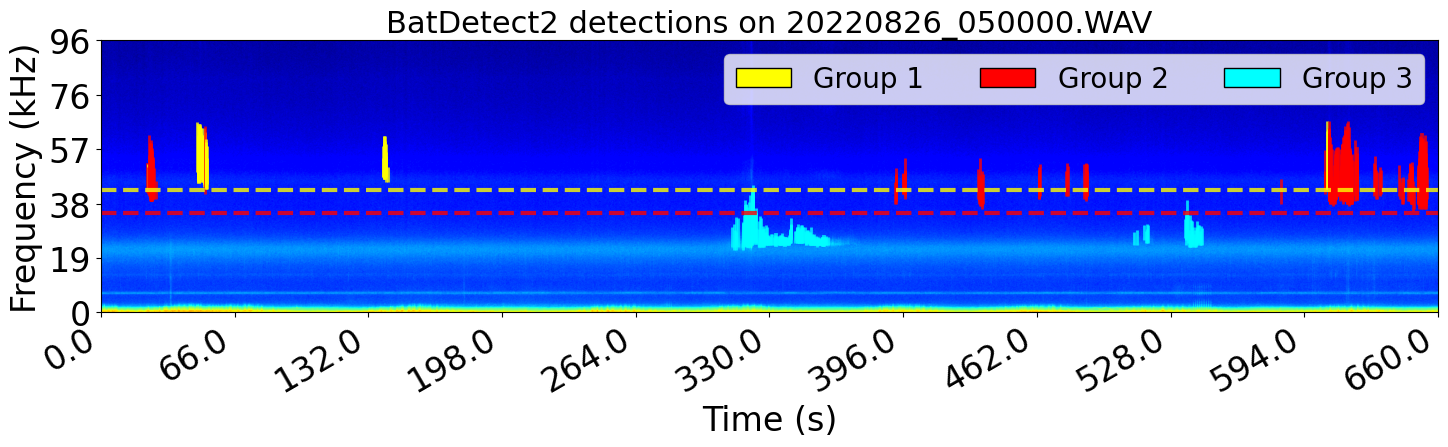

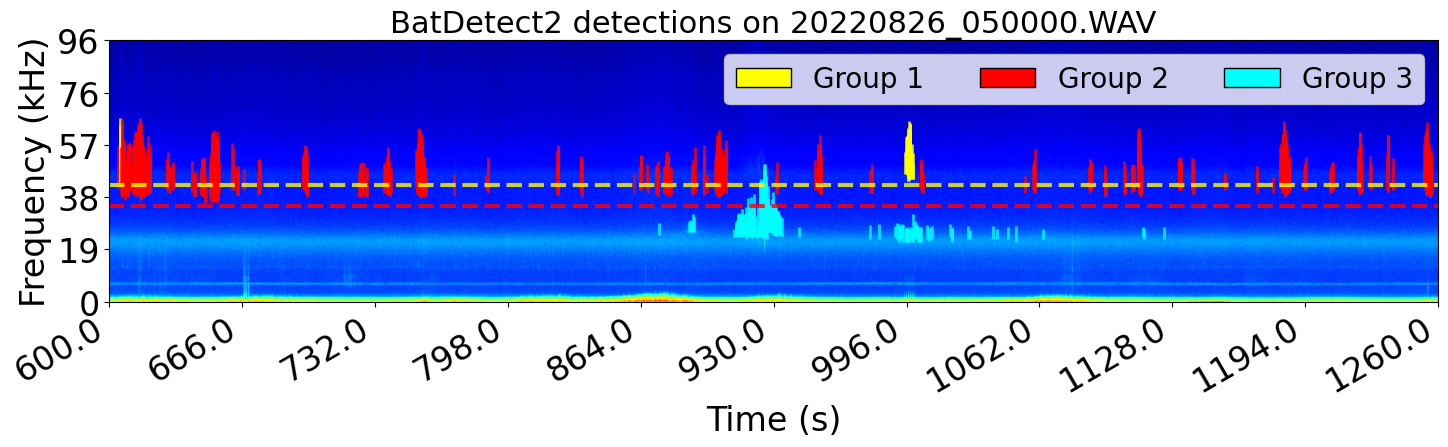

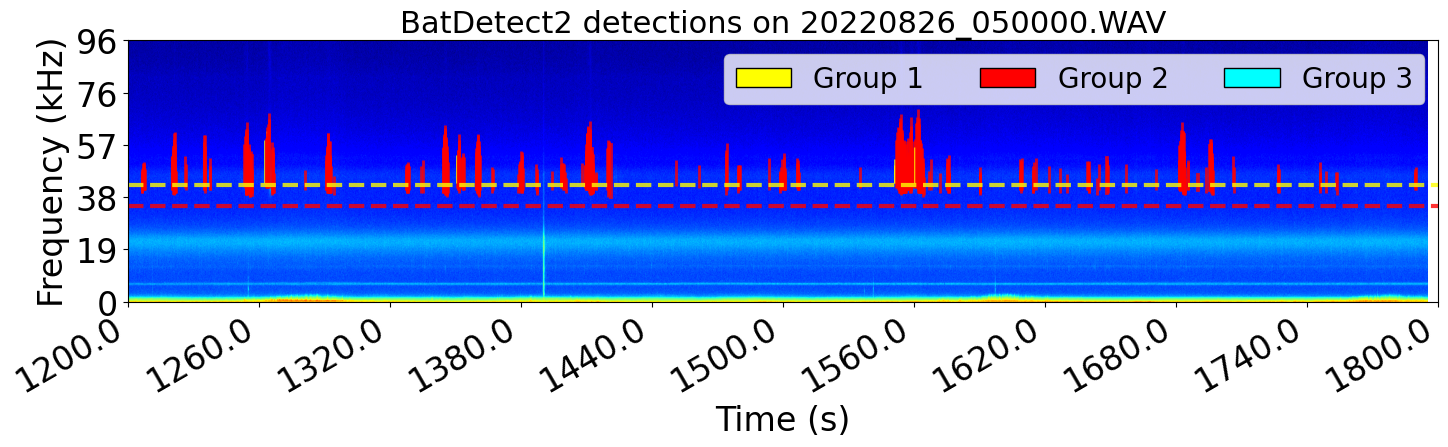

In [7]:
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]

plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets)

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]

plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets)

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1200
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB


data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]

plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets)

In [8]:
filename = '20220826_070000'
filepath_key = f'UBNA_010/{filename}'
reduce = 55

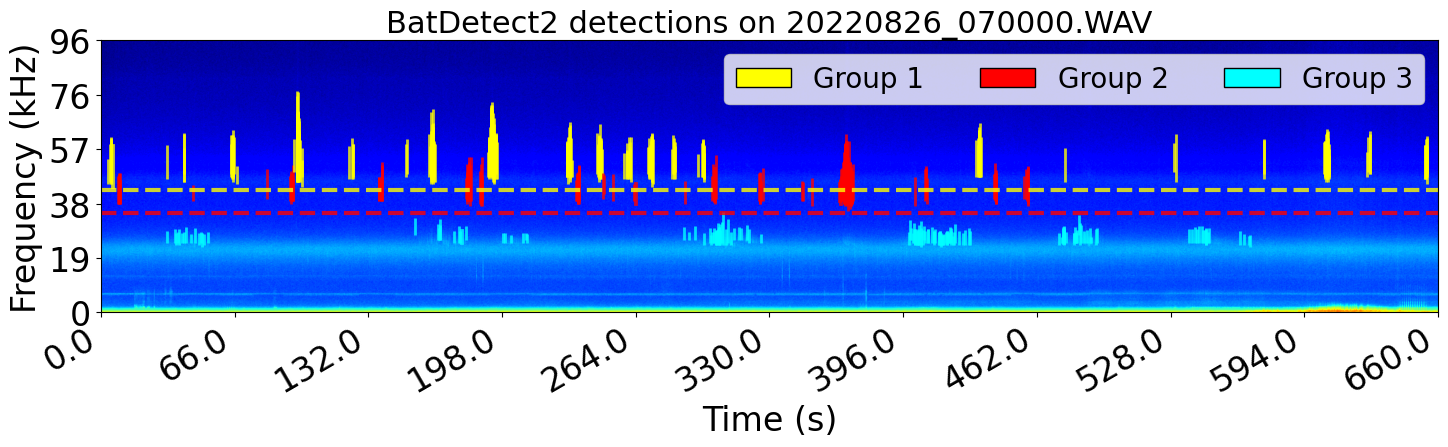

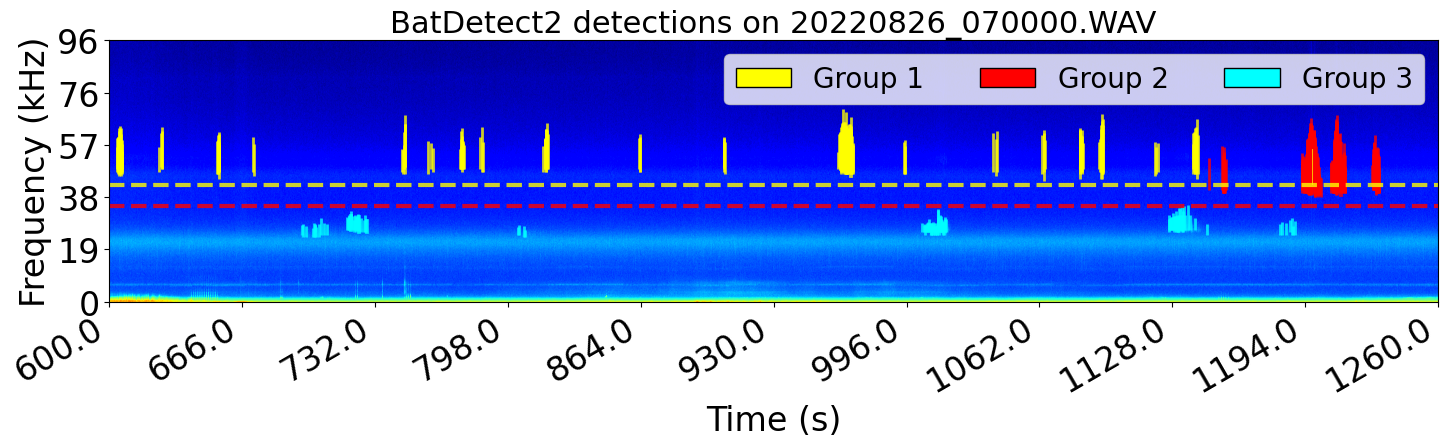

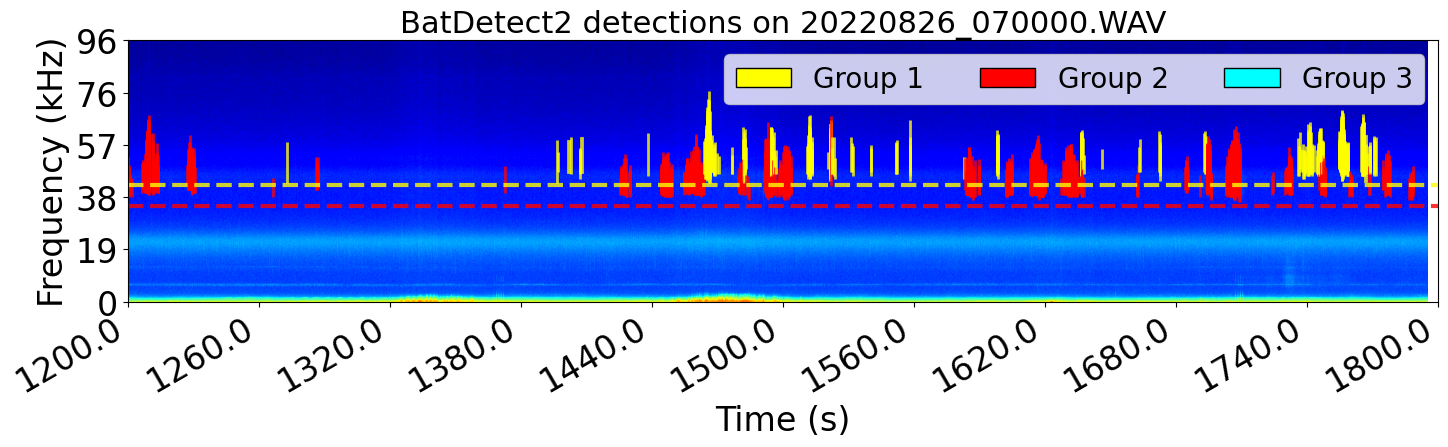

In [9]:
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]

plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets)

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB

data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]

plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets)

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1200
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB


data_params = dict()
data_params['dc_tag'] = '1800of1800'
data_params['freq_tags'] = FREQ_GROUPS[bout_params['freq_key']]

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['dc_tag'])
plot_dets = batdetect2_predictions.loc[np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))]

plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets)